<a href="https://colab.research.google.com/github/tinarobfar/eccdum_assignments/blob/main/6_FinalProject.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install -q eccd_datasets

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
from torch.utils.data import DataLoader, Dataset
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import time
import os
import io
import requests
from PIL import Image
from tempfile import TemporaryDirectory
os.environ["CUDA_LAUNCH_BLOCKING"] = "1"

from eccd_datasets import load_images

cudnn.benchmark = True
plt.ion()   # interactive mode

In [3]:
product_prices = {'Apple': 74, 'Pear': 89, 'Satsumas': 44, 'Melon': 109, 'Orange': 35}
df_images = load_images()
df_images.head()

,dataset,coarse_cat,finegrained_cat,image_data
0,train,Apple,Golden-Delicious,b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00...
1,train,Apple,Golden-Delicious,b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00...
2,train,Apple,Golden-Delicious,b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00...
3,train,Apple,Golden-Delicious,b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00...
4,train,Apple,Golden-Delicious,b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00...


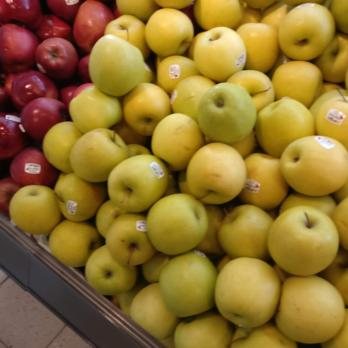

In [4]:
def load_image_data(image_data):
    return Image.open(io.BytesIO(image_data))

image = load_image_data(df_images.iloc[0]["image_data"])
image

In [5]:
# Define transformations for training and validation data
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

# Custom dataset that emulates ImageFolder but from df_images
class CustomImageDataset(Dataset):
    def __init__(self, df, transform=None):
        self.df = df
        self.transform = transform
        self.classes = sorted(df['coarse_cat'].unique())
        self.class_to_idx = {cls_name: i for i, cls_name in enumerate(self.classes)}

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        image_data = self.df.iloc[idx]["image_data"]
        image = Image.open(io.BytesIO(image_data))
        label_name = self.df.iloc[idx]["coarse_cat"]
        label = self.class_to_idx[label_name]

        if self.transform:
            image = self.transform(image)
        return image, label

# Split the dataframe into training and validation sets
train_df = df_images[df_images['dataset'] == 'train']
val_df = df_images[df_images['dataset'] == 'val']

# Create training and validation datasets
image_datasets = {
    'train': CustomImageDataset(train_df, transform=data_transforms['train']),
    'val': CustomImageDataset(val_df, transform=data_transforms['val'])
}

# Create DataLoaders
dataloaders = {
    'train': DataLoader(image_datasets['train'], batch_size=4, shuffle=True, num_workers=4),
    'val': DataLoader(image_datasets['val'], batch_size=4, shuffle=False, num_workers=4)
}

# Calculate the size of each dataset and get the classes
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


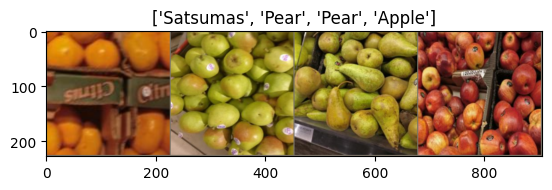

In [6]:
def imshow(inp, title=None):
    """Display image for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

In [7]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    # Create a temporary directory to save training checkpoints
    with TemporaryDirectory() as tempdir:
        best_model_params_path = os.path.join(tempdir, 'best_model_params.pt')

        torch.save(model.state_dict(), best_model_params_path)
        best_acc = 0.0

        for epoch in range(num_epochs):
            print(f'Epoch {epoch}/{num_epochs - 1}')
            print('-' * 10)

            # Each epoch has a training and validation phase
            for phase in ['train', 'val']:
                if phase == 'train':
                    model.train()  # Set model to training mode
                else:
                    model.eval()   # Set model to evaluate mode

                running_loss = 0.0
                running_corrects = 0

                # Iterate over data.
                for inputs, labels in dataloaders[phase]:
                    inputs = inputs.to(device)
                    labels = labels.to(device)

                    # zero the parameter gradients
                    optimizer.zero_grad()

                    # forward
                    # track history if only in train
                    with torch.set_grad_enabled(phase == 'train'):
                        outputs = model(inputs)
                        _, preds = torch.max(outputs, 1)
                        loss = criterion(outputs, labels)

                        # backward + optimize only if in training phase
                        if phase == 'train':
                            loss.backward()
                            optimizer.step()

                    # statistics
                    running_loss += loss.item() * inputs.size(0)
                    running_corrects += torch.sum(preds == labels.data)
                if phase == 'train':
                    scheduler.step()

                epoch_loss = running_loss / dataset_sizes[phase]
                epoch_acc = running_corrects.double() / dataset_sizes[phase]

                print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

                # deep copy the model
                if phase == 'val' and epoch_acc > best_acc:
                    best_acc = epoch_acc
                    torch.save(model.state_dict(), best_model_params_path)

            print()

        time_elapsed = time.time() - since
        print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
        print(f'Best val Acc: {best_acc:4f}')

        # load best model weights
        model.load_state_dict(torch.load(best_model_params_path, weights_only=True))
    return model

In [8]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title(f'predicted: {class_names[preds[j]]}')
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

In [9]:
model_ft = models.resnet18(weights='IMAGENET1K_V1')
num_ftrs = model_ft.fc.in_features
# ``nn.Linear(num_ftrs, len(class_names))``.
model_ft.fc = nn.Linear(num_ftrs, len(class_names))

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

In [10]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=25)

Epoch 0/24
----------
train Loss: 1.0061 Acc: 0.6133
val Loss: 0.4872 Acc: 0.7895

Epoch 1/24
----------
train Loss: 0.7189 Acc: 0.7304
val Loss: 0.4193 Acc: 0.8596

Epoch 2/24
----------
train Loss: 0.7062 Acc: 0.7644
val Loss: 0.4168 Acc: 0.8246

Epoch 3/24
----------
train Loss: 0.6200 Acc: 0.7941
val Loss: 0.1356 Acc: 0.9474

Epoch 4/24
----------
train Loss: 0.5619 Acc: 0.7970
val Loss: 0.3832 Acc: 0.8596

Epoch 5/24
----------
train Loss: 0.4219 Acc: 0.8533
val Loss: 0.1809 Acc: 0.9474

Epoch 6/24
----------
train Loss: 0.4196 Acc: 0.8652
val Loss: 0.2622 Acc: 0.9298

Epoch 7/24
----------
train Loss: 0.2673 Acc: 0.9037
val Loss: 0.2748 Acc: 0.8947

Epoch 8/24
----------
train Loss: 0.2305 Acc: 0.9230
val Loss: 0.2911 Acc: 0.8596

Epoch 9/24
----------
train Loss: 0.2329 Acc: 0.9274
val Loss: 0.3232 Acc: 0.8246

Epoch 10/24
----------
train Loss: 0.1643 Acc: 0.9496
val Loss: 0.2121 Acc: 0.9123

Epoch 11/24
----------
train Loss: 0.2310 Acc: 0.9185
val Loss: 0.2368 Acc: 0.8947

Ep

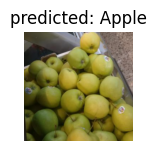

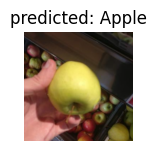

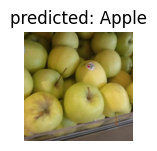

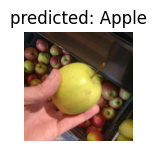

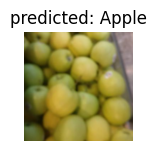

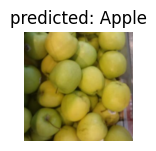

In [11]:
visualize_model(model_ft)

In [12]:
model_conv = torchvision.models.resnet18(weights='IMAGENET1K_V1')
for param in model_conv.parameters():
    param.requires_grad = False

# Parameters of newly constructed modules have requires_grad=True by default
num_ftrs = model_conv.fc.in_features
model_conv.fc = nn.Linear(num_ftrs, len(class_names))

model_conv = model_conv.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that only parameters of final layer are being optimized as
# opposed to before.
optimizer_conv = optim.SGD(model_conv.fc.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)

In [13]:
model_conv = train_model(model_conv, criterion, optimizer_conv,
                         exp_lr_scheduler, num_epochs=25)

Epoch 0/24
----------
train Loss: 1.1289 Acc: 0.5274
val Loss: 0.6731 Acc: 0.7719

Epoch 1/24
----------
train Loss: 0.7657 Acc: 0.7037
val Loss: 0.5858 Acc: 0.7193

Epoch 2/24
----------
train Loss: 0.7093 Acc: 0.7333
val Loss: 0.4951 Acc: 0.8070

Epoch 3/24
----------
train Loss: 0.6771 Acc: 0.7437
val Loss: 0.5424 Acc: 0.8070

Epoch 4/24
----------
train Loss: 0.6349 Acc: 0.7778
val Loss: 0.4379 Acc: 0.8070

Epoch 5/24
----------
train Loss: 0.6275 Acc: 0.7704
val Loss: 0.4018 Acc: 0.8070

Epoch 6/24
----------
train Loss: 0.5614 Acc: 0.7985
val Loss: 0.4209 Acc: 0.8772

Epoch 7/24
----------
train Loss: 0.4945 Acc: 0.8074
val Loss: 0.4203 Acc: 0.8421

Epoch 8/24
----------
train Loss: 0.4504 Acc: 0.8415
val Loss: 0.3881 Acc: 0.8596

Epoch 9/24
----------
train Loss: 0.4439 Acc: 0.8341
val Loss: 0.4393 Acc: 0.8070

Epoch 10/24
----------
train Loss: 0.4377 Acc: 0.8459
val Loss: 0.4531 Acc: 0.8070

Epoch 11/24
----------
train Loss: 0.4790 Acc: 0.8356
val Loss: 0.4065 Acc: 0.8596

Ep

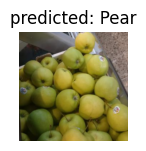

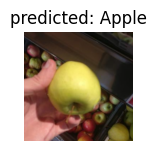

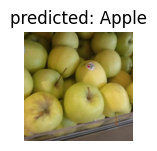

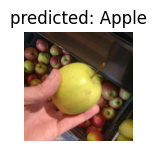

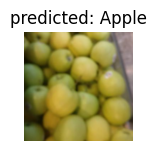

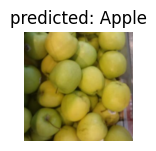

In [14]:
visualize_model(model_conv)

plt.ioff()
plt.show()

In [15]:
def visualize_model_predictions(model, df_images, idx=0):
    was_training = model.training
    model.eval()

    # Select the image from the DataFrame
    image_data = df_images.iloc[idx]["image_data"]  # Use the image index
    img = Image.open(io.BytesIO(image_data))  # Load the image from the binary data
    img = data_transforms['val'](img)  # Apply the validation transformation
    img = img.unsqueeze(0)  # Add batch dimension
    img = img.to(device)  # Move image to the device (GPU/CPU)

    with torch.no_grad():
        outputs = model(img)  # Perform the prediction
        _, preds = torch.max(outputs, 1)  # Get the predicted class

        # Create the visualization
        ax = plt.subplot(2, 2, 1)
        ax.axis('off')
        ax.set_title(f'Predicted: {class_names[preds[0]]}')
        imshow(img.cpu().data[0])  # Display the image

        model.train(mode=was_training)  # Restore the model to training mode


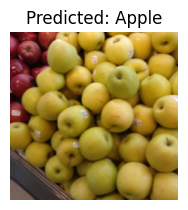

In [16]:
visualize_model_predictions(model_ft, df_images, idx=0)

plt.ioff()
plt.show()

In [17]:
# Function to evaluate the model
def evaluate_model(model, dataloader):
    model.eval()
    predictions, actuals = [], []
    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            predictions.extend(preds.cpu().numpy())
            actuals.extend(labels.cpu().numpy())
    accuracy = accuracy_score(actuals, predictions)
    return accuracy, predictions, actuals

# Evaluate the model on the validation dataset
accuracy, preds, labels = evaluate_model(model_ft, dataloaders['val'])
print(f'Model Accuracy: {accuracy * 100:.2f}%')

Model Accuracy: 94.74%


In [18]:
# Model evaluation
def evaluate_model(model, dataloader):
    model.eval()
    predictions, actuals = [], []
    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            predictions.extend(preds.cpu().numpy())
            actuals.extend(labels.cpu().numpy())
    accuracy = accuracy_score(actuals, predictions)
    return accuracy, predictions, actuals

accuracy, preds, labels = evaluate_model(model_ft, dataloaders['val'])
print(f'Model Accuracy: {accuracy * 100:.2f}%')

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Model Accuracy: 94.74%


In [19]:
def calculate_cost(predictions, actuals, prices):
    total_cost = 0
    for pred, actual in zip(predictions, actuals):
        # Get the corresponding labels
        pred_label = class_names[pred]  # Or use 'pred' directly if it's the index
        actual_label = class_names[actual]  # Or use 'actual' directly if it's the index

        # Get the price for each class
        pred_price = prices.get(pred_label, 0)  # Default to 0 if the key doesn't exist
        actual_price = prices.get(actual_label, 0)  # Same for the actual label

        # Check if the price is missing
        if pred_price == 0 or actual_price == 0:
            print(f"Warning: Missing price for {pred_label} or {actual_label}. Using 0.")

        # Calculate the cost based on the prediction vs the actual value
        if pred > actual:  # The customer pays too much
            total_cost += 5 * (pred_price - actual_price)  # Multiply by 5 as a penalty
        elif pred < actual:  # The customer pays too little
            total_cost += (actual_price - pred_price)

    return total_cost

# Calculate the total cost based on predictions in the test set
total_cost = calculate_cost(preds, labels, product_prices)
print(f'Total Cost for Misclassifications: ${total_cost:.2f}')


Total Cost for Misclassifications: $40.00
